In [1]:
import pandas as pd
import numpy as np

# Plotting tools
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud as wc
from wordcloud import STOPWORDS
import scikitplot.metrics as skplt
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Text Cleaning and Preprocessing
from collections import Counter
from scipy.stats import expon
import unicodedata
import re
import string
from textblob import TextBlob
import spacy

import nltk
from nltk.corpus import stopwords

# sklearn
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import xgboost as xgb

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Enable logging (for gensim)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import time
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#export model to a file
import joblib

/opt/conda/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/opt/conda/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
/opt/conda/lib/python3.7/site-packages/nltk/lm/vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Counter, Iterable
/opt/conda/lib/python3.7/site-packages/gensim/corpora/dictionary.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3

## Flair Labels

In [2]:
flairs = ['Politics', 'Photography', 'Policy/Economy', 'AskIndia', 'Sports', 'Non-Political', 'Scheduled', 
          'Science/Technology', 'Food', 'Business/Finance', 'Coronavirus', 'AMA', '[R]eddiquette']

## Reading the Data

In [3]:
flair_data = pd.read_csv("data/data_200.csv")

In [4]:
flair_data.sample(5)

body  \
1702                                                NaN   
2355                                                NaN   
1050  unattractive socially awkward person hardly fr...   
409                                                 NaN   
2449  >A team of 130 trained volunteers from across ...   

                                                comment       created      id  \
1702  anyones living wb hows life outside kolkata so...  1.561486e+09  c568na   
2355  Ek baar fine diya!\n\nPhir gaandfaad fine liya...  1.568026e+09  d1p9fl   
1050  look partner think best traitany instances you...  1.551630e+09  aws4pb   
409   someone shoots weddings http iimgurcom v8iqjro...  1.445537e+09  3pr6rq   
2449                                                NaN  1.586677e+09  fzsi3s   

                                                  title  \
1702  west bengal protests politicians hounded retur...   
2355  My Car Was Fined Too for Speeding in Mumbai, S...   
1050  casual ama 37 kissless handholdless hugless vi...   
409             indian couples going nude wedding shoot   
2449  With lockdown stressing out the mind, Hyderaba...   

                                                    url          label  
1702  https://www.bbc.com/news/world-asia-india-4874...       Politics  
2355  https://www.news18.com/news/india/my-car-was-f...  [R]eddiquette  
1050  https://www.reddit.com/r/india/comments/aws4pb...            AMA  
409   http://timesofindia.indiatimes.com/life-style/...    Photography  
2449  https://www.reddit.com/r/india/comments/fzsi3s...    Coronavirus

## Histogram for Sample Count
To confirm that the data scraped is balanced and unbiased per flair

In [5]:
flair_data['label'].value_counts()

Sports                200
Scheduled             200
[R]eddiquette         200
Business/Finance      200
AskIndia              200
Science/Technology    200
Non-Political         200
Policy/Economy        200
AMA                   200
Food                  200
Politics              200
Photography           200
Coronavirus           200
Name: label, dtype: int64

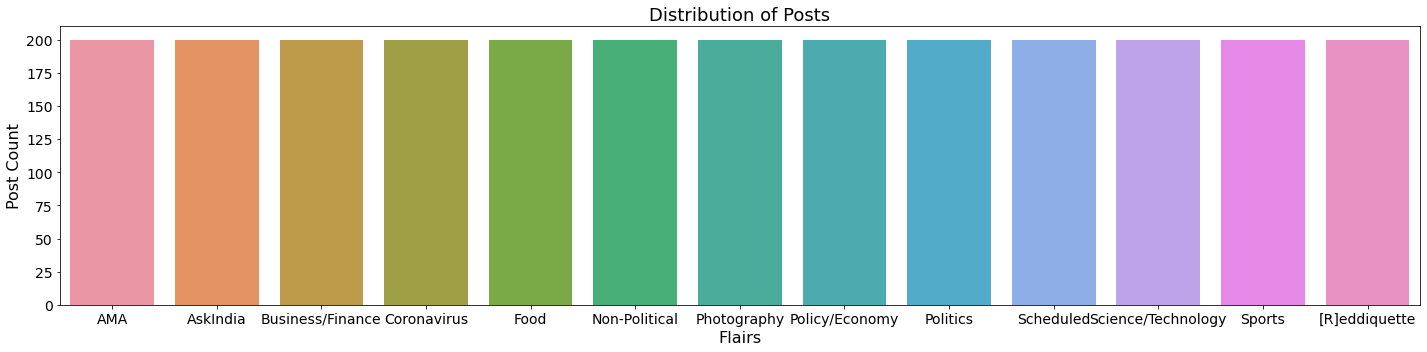

In [6]:
def barplot(df, x, y, title, label, ylabel, dim, orient = "v", ci = False, hue = None):
    
    plt.figure(figsize = dim, facecolor = "white")
    sns.barplot(x = x, y = y, data = df, orient = orient, ci = ci, hue = hue)
    plt.title(f"{title}", size = 18)
    plt.xlabel(f"{label}", size = 16)
    plt.ylabel(f"{ylabel}", size = 16)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.tight_layout();
    

df = (flair_data.set_index(['id', 'label']).count(level='label'))

barplot(df = df,
        x = df.index,
        y = "url",
        title = "Distribution of Posts",
        label = "Flairs",
        ylabel = "Post Count",
        dim = (20,5))

**Observation:** My intuition was correct and the data is balanced (sampled 200 each flairwise)

### Checking for Null Values

In [7]:
print("Null value counts for each Feature: ")
flair_data.isna().sum()

Null value counts for each Feature: 


body       1469
comment     151
created       0
id            0
title         0
url           0
label         0
dtype: int64

**Observtion:** As I suspected, some posts are less active & hence don't gather much user attention and some submissions that contain multimedia links (i.reddit, v.reddit, imgur, Youtube, Twitter, etc..) lack a selftext body.

## Combining Features
Creating a new feature 'combined' which consists of the submission url, title, selftext and top comments. Taking into account the size of the dataset scraped and the presence of null values within the body and top comments, dropping null-valued tuples will result in data loss, class imbalance and therefore, poor accuracy of the classifier. Moreover, the features combined are a subset of 'combined' which implies we get the best of the other features present.

In [8]:
# combining features
flair_data["combined"] = flair_data["url"].map(str) + " " + flair_data["title"].map(str) + " " + flair_data["body"].map(str) + " " + flair_data["comment"].map(str)
flair_data.head(1)

body  \
0  reposting lack activity r askindiahello last y...   

                                             comment       created      id  \
0  dear policy holder dhavalcoholic request help ...  1.386254e+09  1s57oi   

                                               title  \
0  need feedback insurance policy took xpost aski...   

                                                 url     label  \
0  https://www.reddit.com/r/india/comments/1s57oi...  AskIndia   

                                            combined  
0  https://www.reddit.com/r/india/comments/1s57oi...

## Data Cleaning
Cleaning and Preprocessing the combined text as usual; I detected a presence of urls (http...), subreddits (r/...), and users (u/...) referenced within the comments and self text along with special formatting characters that resembled markdown (>, #, \[, \], etc), zero-width spaces (&#x200B), ASCII spaces (\n, \t, etc) and a few HTML tags (&nbsp). Moreover, I extended the list of stopwords based on observaions that occured in each flair from the [word cloud and most frequently occuring words](http://34.73.225.220:4444/notebooks/Part%202%20-%20EDA%2C%20Data%20Preprocessing%20and%20Feature%20Engineering.ipynb#Frequently-occuring-words-(per-Flair)).

In [9]:
#cleaning combined data
stop_words = stopwords.words('english') # stopwords
extended =  ['nan', 'https','http', 'redd','com', 'reddit', 'wwwredditcom', 'get', 'imgurcom', 'iimgurcom', 'www', 'x200b', 'nbsp', 'like', 'dont', 'people', 'india', 'indian', 'time', 'good', 'want', 'think', 'know', 'need', 'make', 'thing', 'year', 'day', 'reddit', 'comments', 'comment']
stop_words.extend(extended)

def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_text(sentence):
    if type(sentence) == type('a'):
        sentence = unicodeToAscii(sentence.lower().strip())
        sentence = re.sub(r"([.!?])", r" \1", sentence)
        sentence = re.sub(r'[/(){}\[\]\|@,;:.]', r' ', str(sentence))
        sentence = re.sub(r"[^a-z]+", r" ", sentence)
        sentence = ' '.join(word for word in sentence.split() if word not in stop_words and len(word)>2)
        return sentence

In [10]:
flair_data["combined_cleaned"]  = flair_data["combined"].apply(lambda x: clean_text(x))

## Text Normalization
Even though the goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form, I chose lemmatization because processing time wasn't a big issue and I wanted a better normaliztion. Moreover, it's easier to find the occurrences of Part of Speech with spacy.

In [11]:
#POS Tagging (takes time to process)
nlp = spacy.load('en_core_web_sm')
total_tokens = []
freq = {}
for submission in flair_data['combined_cleaned']:
    doc = nlp(submission)
    tokens = []
    for word in doc:
        pos = word.pos_
        if (pos in freq): 
            freq[pos] += 1
        else: 
            freq[pos] = 1
        tokens.append(pos)
        
    total_tokens.append(tokens)
    
pos_df = pd.DataFrame({'POS': list(freq.keys()), 'Frequency':list(freq.values())})

### Part-of-Speech Distribution

      POS  Frequency
0    VERB     139202
1    NOUN     228608
2   PROPN     126325
3     ADJ      78591
4     ADV      36517
5     ADP       5929
6   CCONJ        689
7    INTJ       2481
8   SCONJ       2786
9    PRON       7054
10      X       1066
11    AUX       1645
12   PART       3359
13    NUM       5288
14    DET       2763
15  PUNCT         25
16    SYM          7

Part-of-speech tagging counts for combined corpus


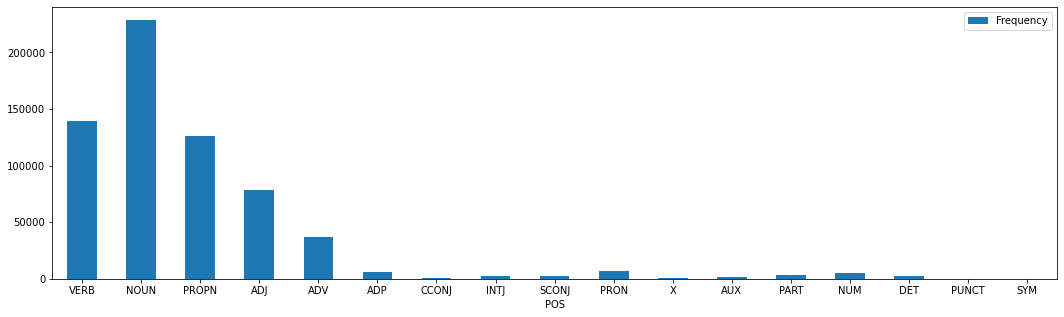

In [12]:
print(pos_df)
print('\nPart-of-speech tagging counts for combined corpus')
pos_df.plot.bar(x ='POS', y ='Frequency', rot = 0, figsize=(18,5))

### Text Lemmatization
Hence I proceeded to exclude the POS components I assumed would affect my classification, for eg. the base32 encoded id of urls left over after previous cleaning and substitutions ('3g1jfi' of https://www.reddit.com/r/funny/comments/3g1jfi/buttons/), Cardinal Digits, Pronouns, etc.

In [13]:
# Takes time to process
allowed_postags=['PROPN', 'VERB', 'NOUN', 'ADV', 'ADJ'] # According to occurence in POS Tagging 

lemmatized_submissions = []
for submission in flair_data['combined_cleaned']:
    doc = nlp(submission)
    submission = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    lemmatized_submissions.append(" ".join(submission))
    
flair_data['combined_lemmatized'] = lemmatized_submissions

In [14]:
flair_data['combined_lemmatized']

0       feedback insurance policy take feedback insura...
1       pvwt kill full family kill full family local p...
2       bdfid ambassador take newly issue ambassador t...
3       randians afraid ask randians afraid ask tooafr...
4       ntue askindia cingari cengar tzengar askindia ...
                              ...                        
2595    selfbiohacks coronavirus hotspots thane contai...
2596    fzs could have see covid case apr could see co...
2597    freepressjournal thoosmitaprakashthoo thoosudh...
2598    livemint news innovator fight corona drone rob...
2599    fzzfgn coronavirus several target miss still c...
Name: combined_lemmatized, Length: 2600, dtype: object

## Frequently occuring words (per Flair)
I analyzed these statistics in hopes of finding redundant stopwords that occur (in every flair) frequently.

In [15]:
def plot_most_frequent_words(df, flair):
    cnt = 0
    fig = plt.figure(figsize   = (24,20), facecolor = "white")   
    cnt += 1
    ax = fig.add_subplot(2, 2, cnt)

    sns.barplot(x = 0, y = df.index, data = df, palette = "deep")

    # Configurong Graph parameters
    plt.title(f"Most Common Words from {flair} are", size = 20)
    plt.xlabel("Frequency", size = 18)
    plt.ylabel("Word", size = 18)
    plt.xticks(size = 16)
    plt.yticks(size = 17)

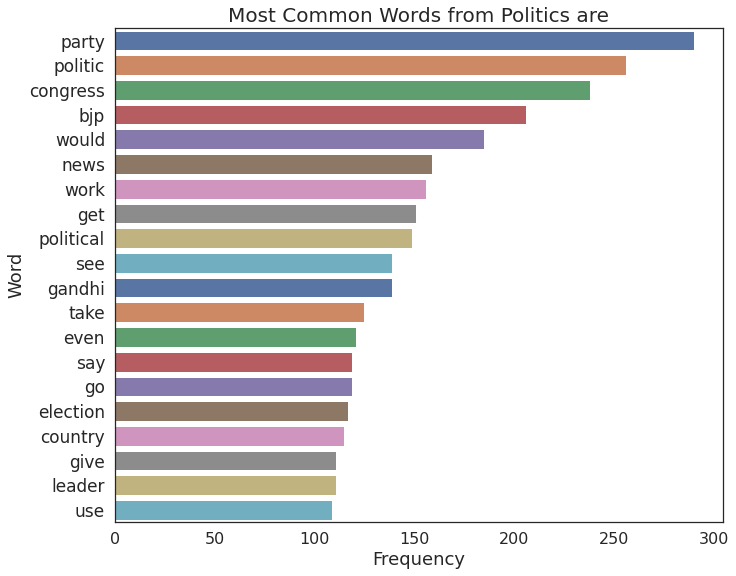

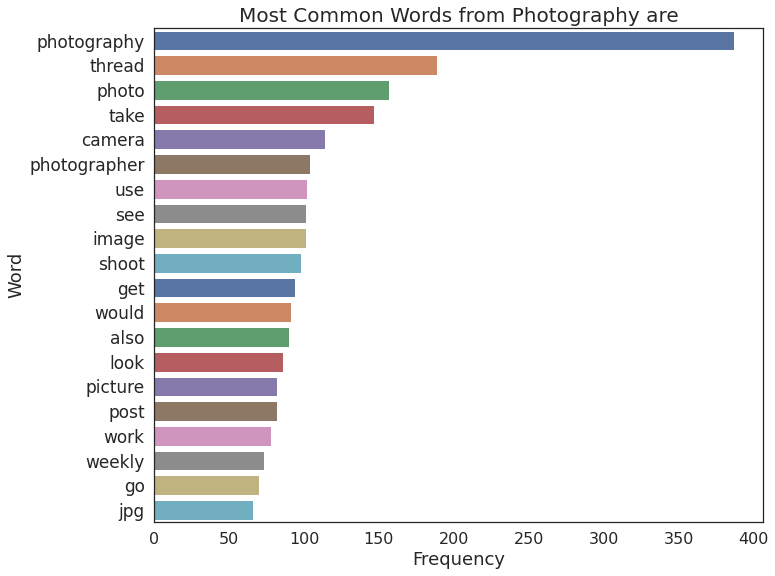

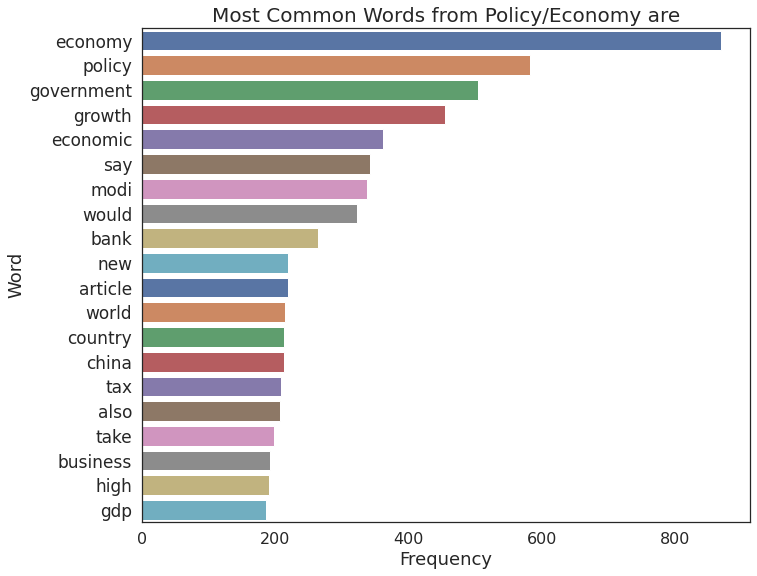

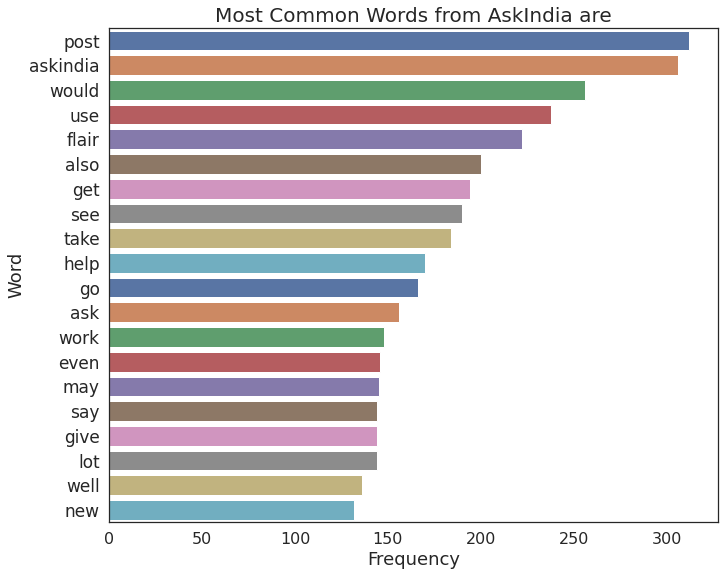

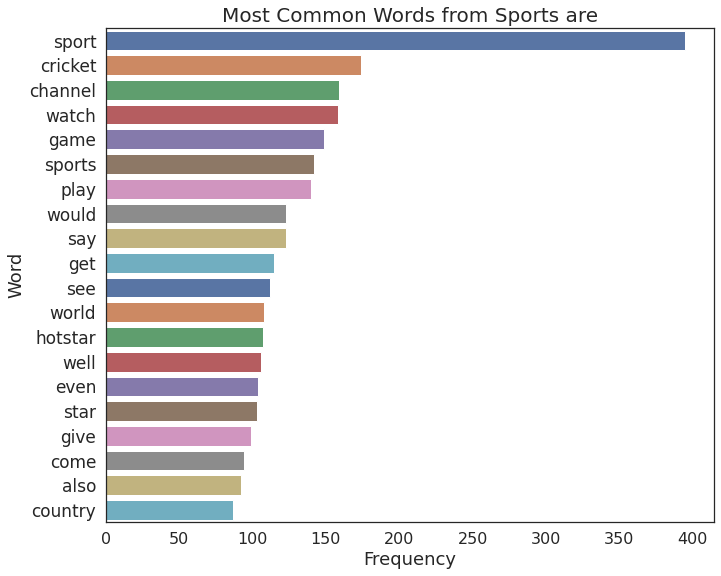

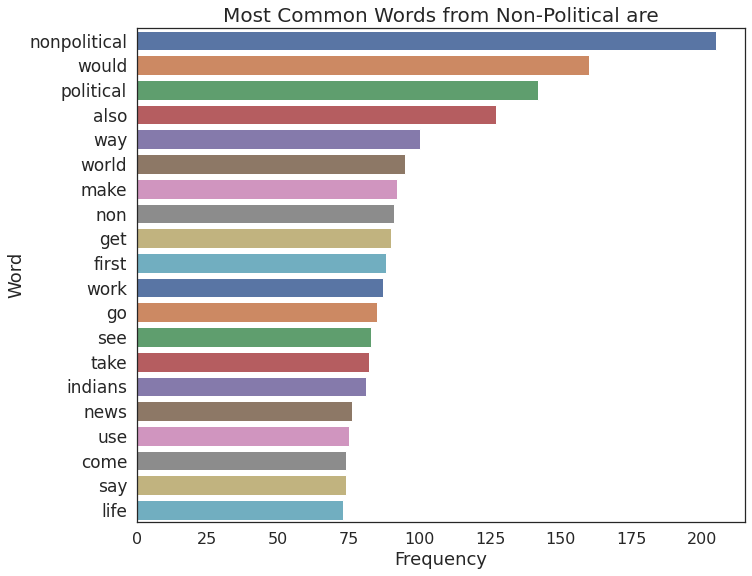

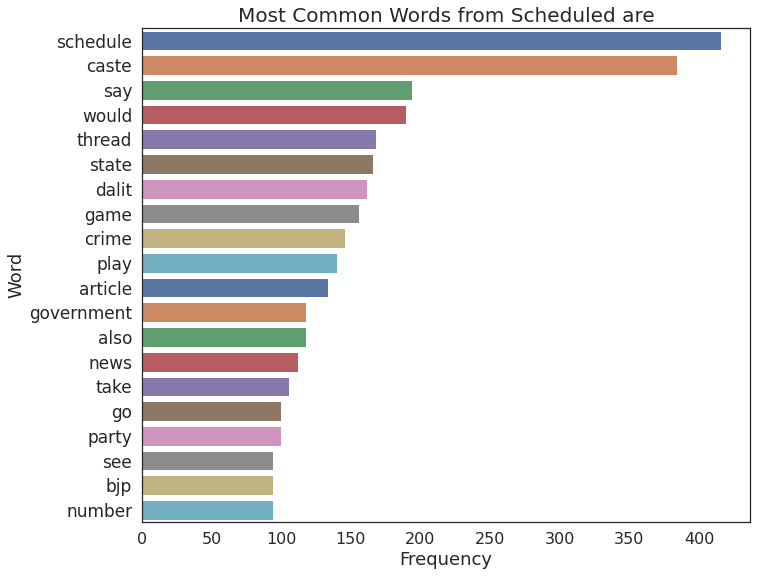

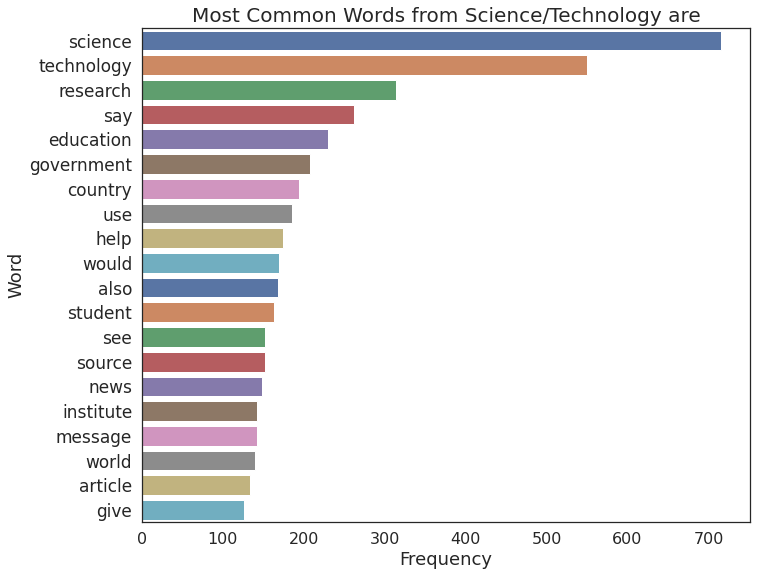

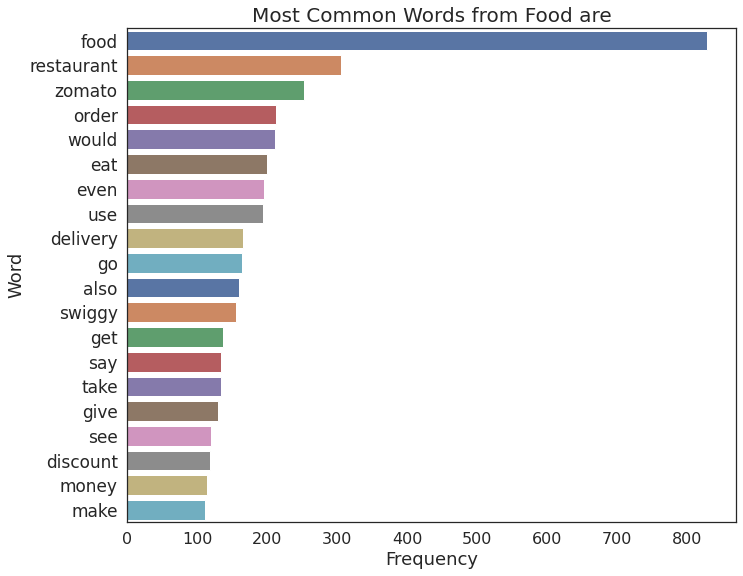

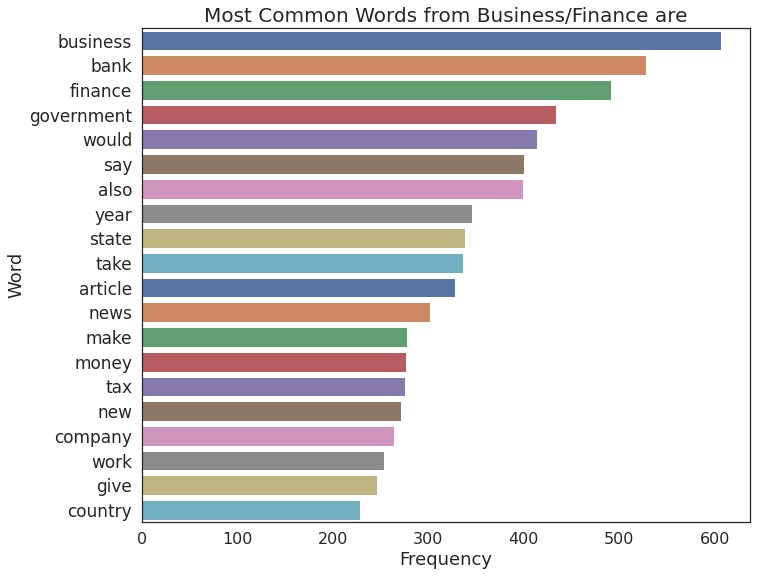

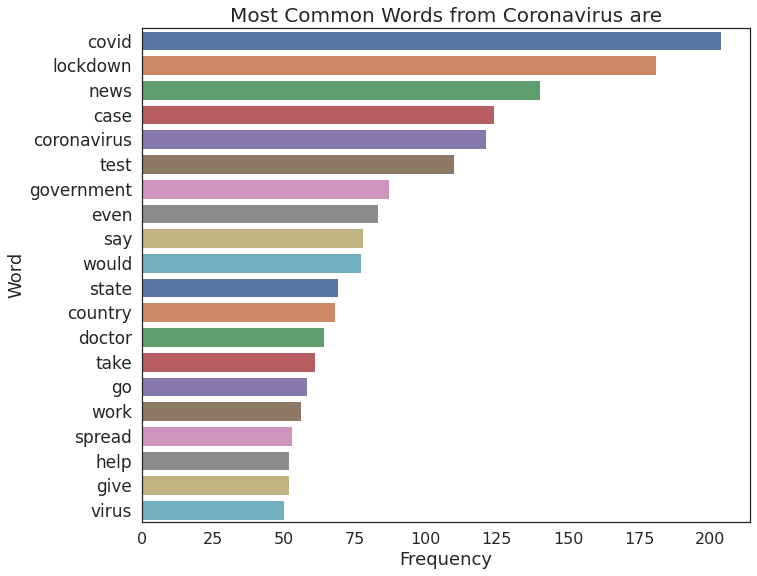

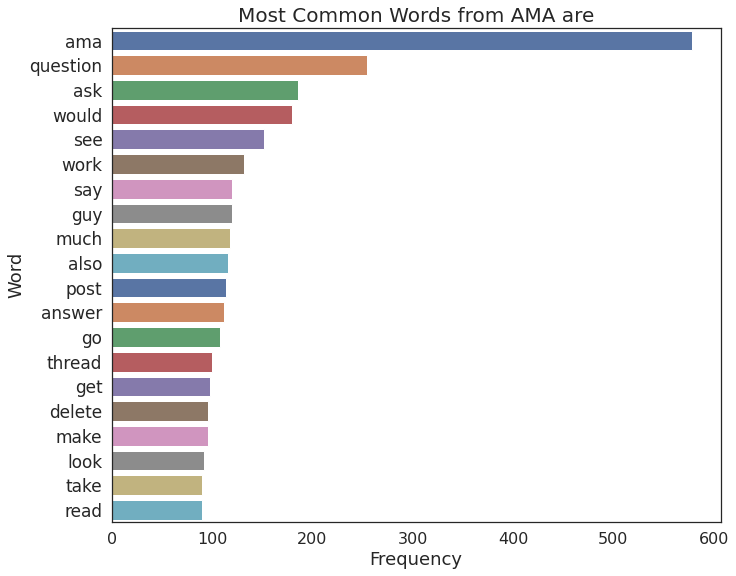

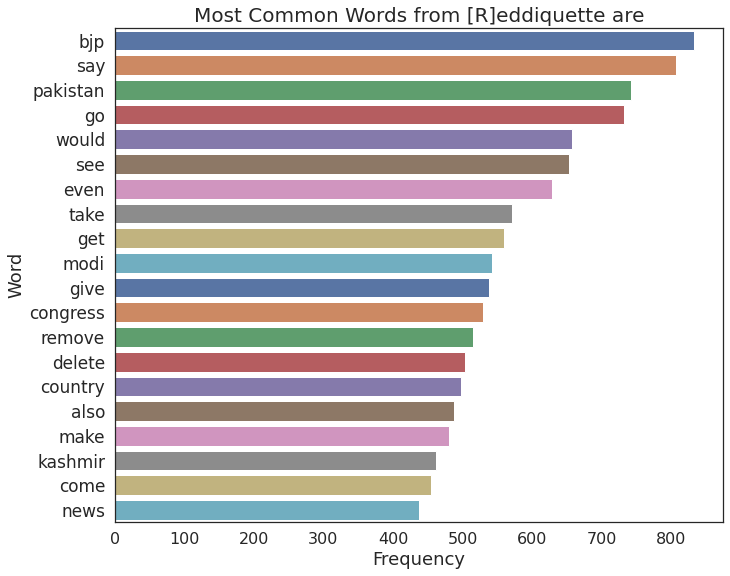

In [16]:
sns.set(style="white", palette = "deep")
cvec = CountVectorizer()

for flair in flairs:
    subset = flair_data[flair_data["label"] == flair]
    vecs = cvec.fit_transform(subset["combined_lemmatized"])
    vectorized_df = pd.DataFrame(vecs.toarray(), columns = cvec.get_feature_names())

    # Getting the 20 most frequent words from each
    frequent = pd.DataFrame(vectorized_df.sum().sort_values(ascending = False).head(20))
    
    plot_most_frequent_words(df = frequent, flair = flair)

Politics:


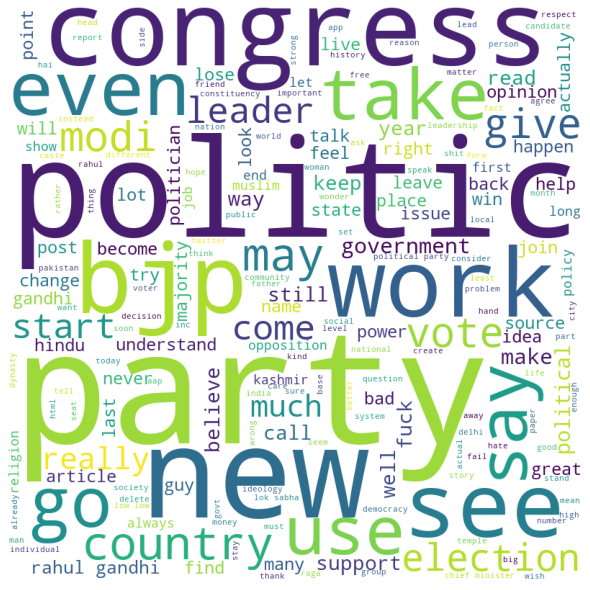





Photography:


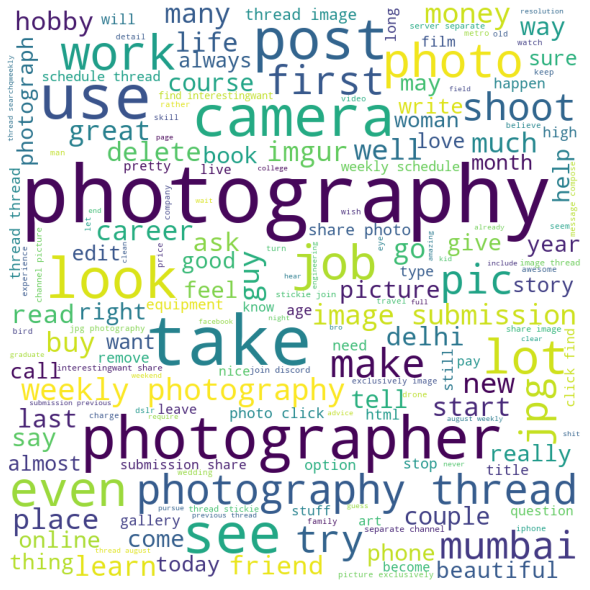





Policy/Economy:


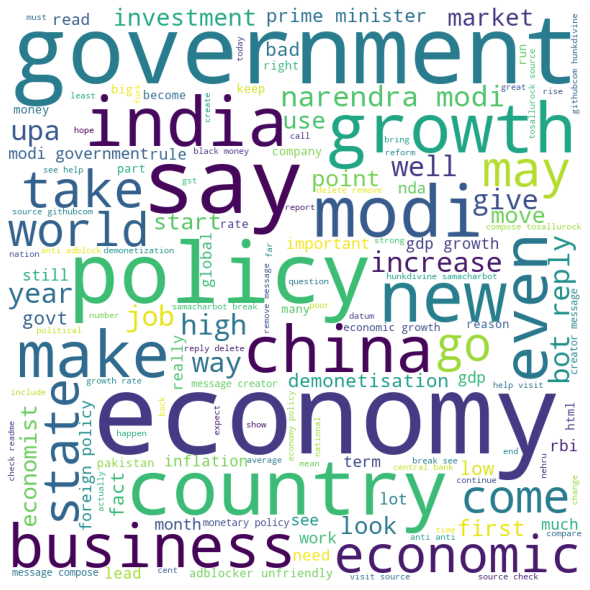





AskIndia:


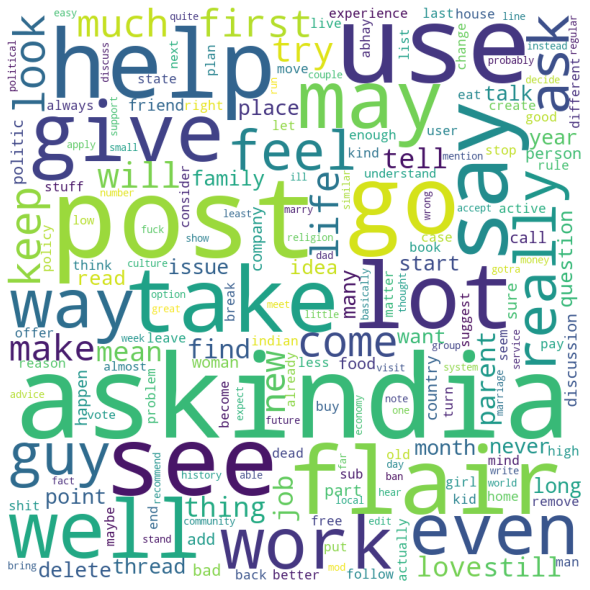





Sports:


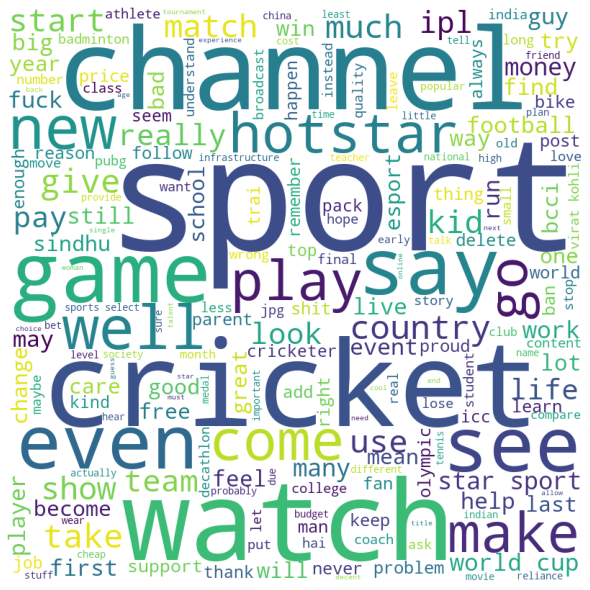





Non-Political:


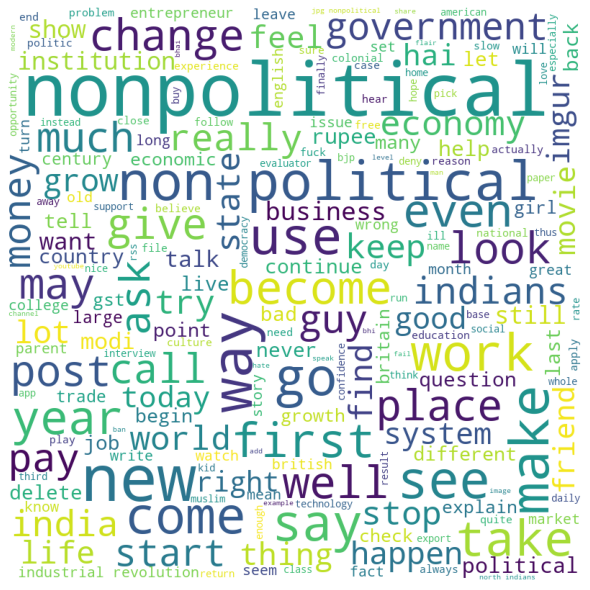





Scheduled:


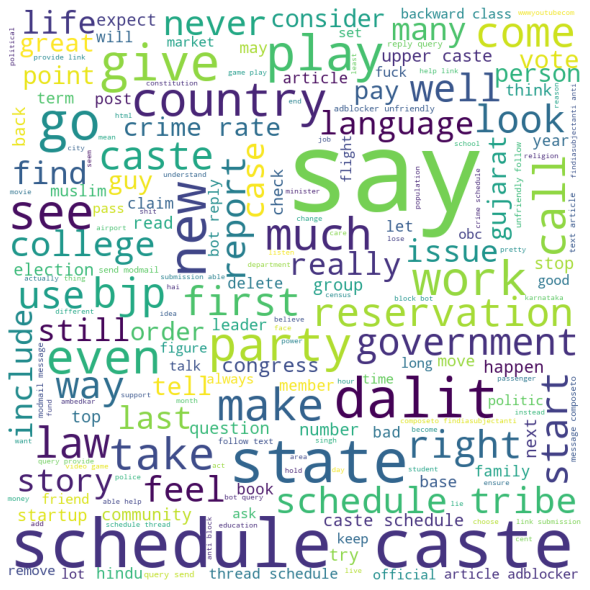





Science/Technology:


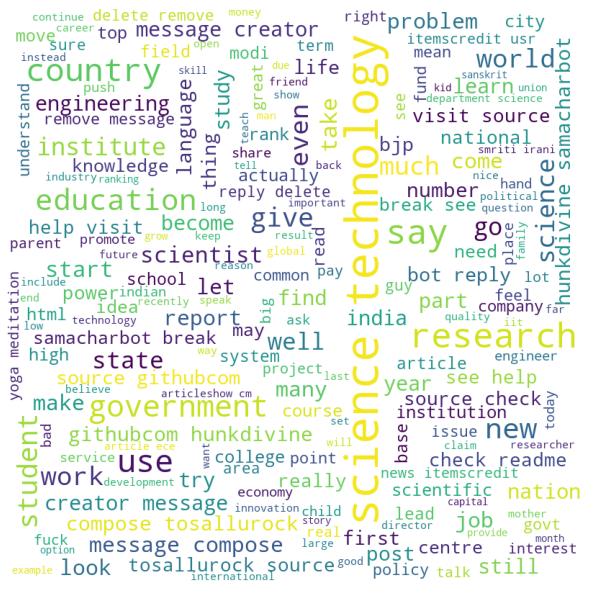





Food:


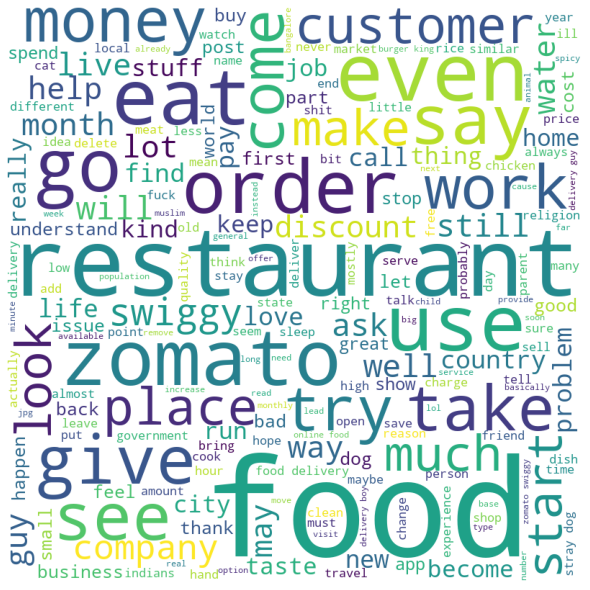





Business/Finance:


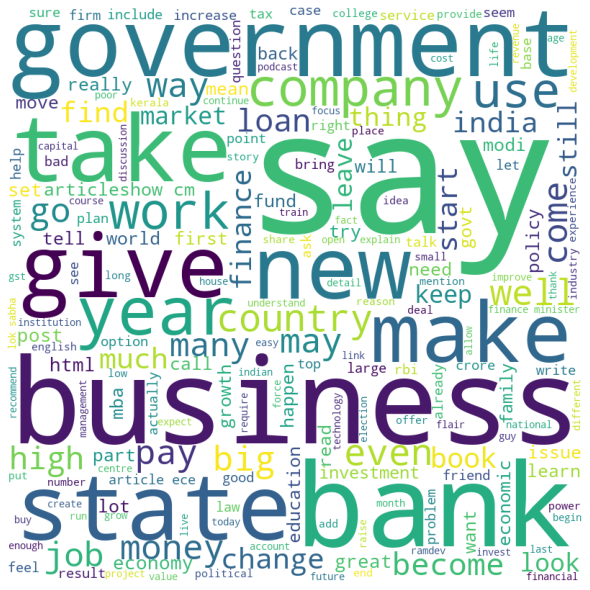





Coronavirus:


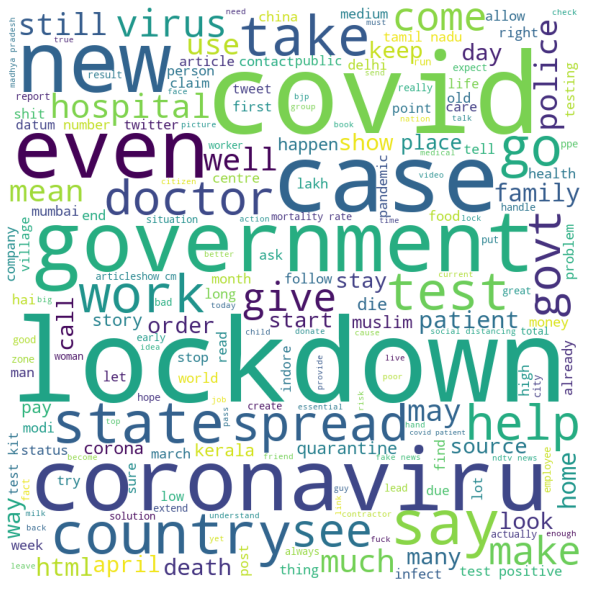





AMA:


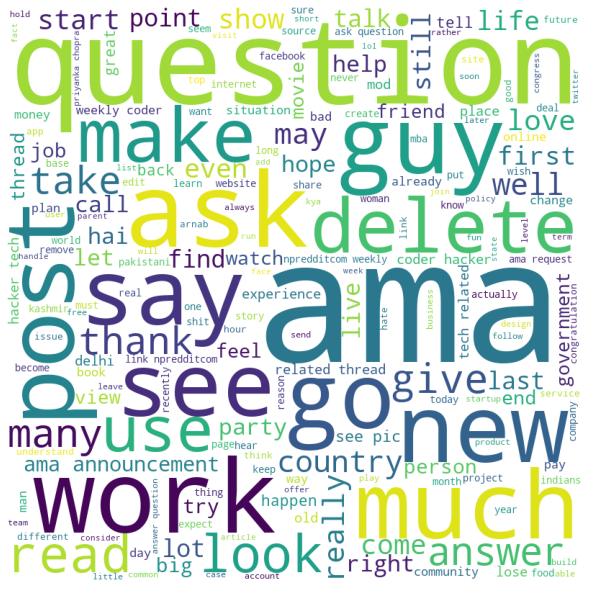





[R]eddiquette:


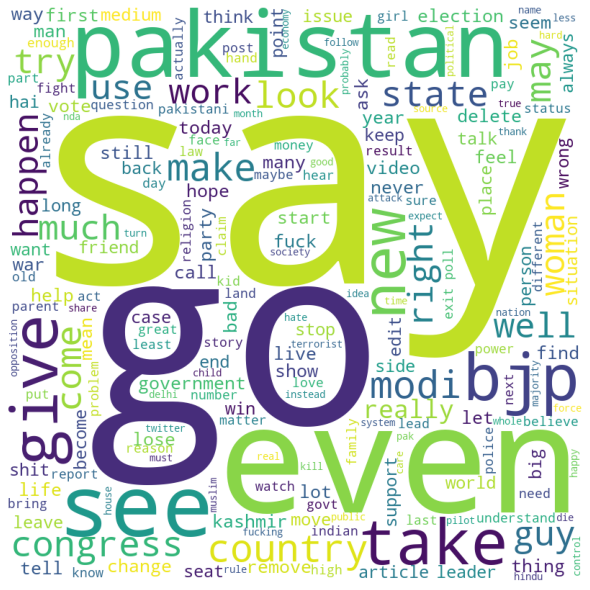

In [17]:
# Word Cloud per Flair

for flair in flairs:
    words = ''
    stopwords = set(STOPWORDS)

    for val in flair_data[flair_data["label"]==flair]['combined_lemmatized']: 
        tokens = str(val).split() 
        words += " ".join(tokens)+" "

    wordcloud = wc(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(words) 

    # plotting the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    print(f"{flair}:")
    plt.show()
    print("\n\n\n")

**Observation:** I conclude that _['nan', 'https', 'http', 'redd','com', 'reddit', 'wwwredditcom', 'get', 'imgurcom', 'iimgurcom', 'www', 'x200b', 'nbsp', 'like', 'dont', 'people', 'india', 'indian', 'time', 'good', 'want', 'think', 'know', 'need', 'make', 'thing', 'year', 'day', 'reddit', 'comments', 'comment']_ are present frequently in every flair. Moreover, these plots present an accurate picture of the distribution and type of words in these flairs themselves


## Text and Word Length Statistics

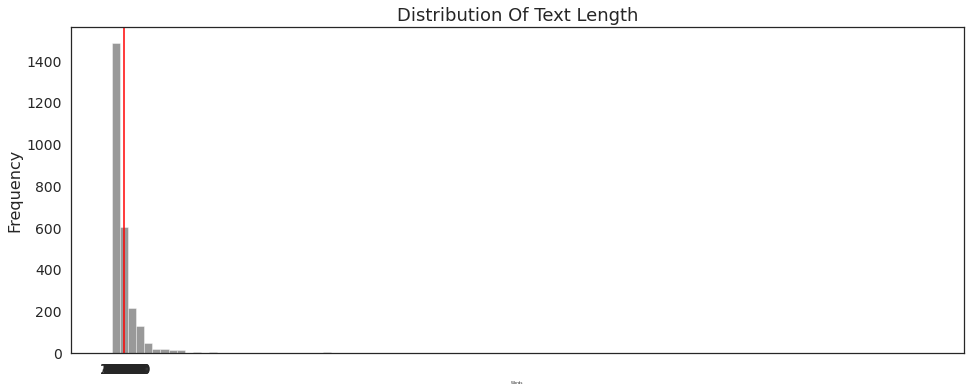

In [18]:
lengths = [len(text) for text in flair_data["combined_lemmatized"]] # text lengths

plt.figure(figsize = (16,6), facecolor = "white")
sns.distplot(lengths, kde = False, bins = 100, color = "black")
plt.axvline(np.mean(lengths), color = "red") # the mean length
plt.title("Distribution Of Text Length", size = 18)
plt.xlabel("Words", size = 4)
plt.ylabel("Frequency", size = 16)
plt.xticks(np.arange(0,2895,100), size = 14)
plt.yticks(size = 14);

## Topic Modelling
Finding correlation and codependencies between words and topics generated. 

In [19]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
data_words = list(sent_to_words(flair_data['combined_lemmatized']))

In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_bigrams = make_bigrams(data_words)

In [21]:
id2word = corpora.Dictionary(data_words_bigrams) # Create Dictionary
texts = data_words_bigrams # Create Corpus
corpus = [id2word.doc2bow(text) for text in texts] # Term Document Frequency

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=6)

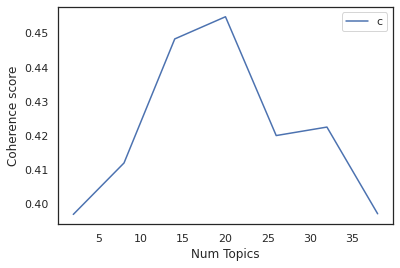

Num Topics = 2  has Coherence Value of 0.3969
Num Topics = 8  has Coherence Value of 0.412
Num Topics = 14  has Coherence Value of 0.4483
Num Topics = 20  has Coherence Value of 0.4548
Num Topics = 26  has Coherence Value of 0.42
Num Topics = 32  has Coherence Value of 0.4225
Num Topics = 38  has Coherence Value of 0.3971


In [24]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [49]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint.pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.026*"economy" + 0.026*"world" + 0.018*"country" + 0.017*"economic" + '
  '0.017*"china" + 0.016*"growth" + 0.009*"india" + 0.009*"also" + '
  '0.009*"global" + 0.009*"large"'),
 (1,
  '0.011*"get" + 0.011*"go" + 0.010*"work" + 0.009*"would" + 0.009*"even" + '
  '0.009*"take" + 0.008*"give" + 0.008*"also" + 0.008*"try" + 0.008*"much"'),
 (2,
  '0.171*"food" + 0.070*"eat" + 0.021*"milk" + 0.019*"aaj" + 0.017*"cook" + '
  '0.016*"meat" + 0.014*"gaya" + 0.013*"landing" + 0.013*"airport" + '
  '0.012*"late_night"'),
 (3,
  '0.297*"pakistan" + 0.171*"kashmir" + 0.030*"border" + 0.020*"statement" + '
  '0.018*"defence" + 0.018*"sexual" + 0.011*"associate" + 0.010*"intelligence" '
  '+ 0.009*"mess" + 0.006*"soil"'),
 (4,
  '0.025*"weight" + 0.022*"football" + 0.022*"transaction" + 0.019*"bar" + '
  '0.018*"curve" + 0.017*"consumption" + 0.016*"volume" + 0.015*"wide" + '
  '0.015*"fat" + 0.014*"payment"'),
 (5,
  '0.035*"authority" + 0.029*"koi" + 0.026*"shop" + 0.020*"bengal" + '
  '

In [50]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.441675 -0.129237       1        1  35.159092
9     -0.425037  0.004167       2        1  16.558229
18    -0.379730 -0.258356       3        1  15.869221
11    -0.217160 -0.401543       4        1  10.700432
0     -0.293942  0.292743       5        1   8.119243
10    -0.401584  0.171605       6        1   6.517169
2     -0.010910  0.352919       7        1   1.220373
13    -0.028227 -0.222189       8        1   1.190794
17     0.132244 -0.308633       9        1   0.845102
5      0.267649 -0.220865      10        1   0.811180
15     0.367752 -0.058063      11        1   0.735755
3      0.218996  0.341624      12        1   0.723726
16     0.082901  0.009891      13        1   0.388244
4      0.218885  0.108760      14        1   0.267189
6      0.070210  0.106402      15        1   0.260994
8      0.146482  0.135545      16        1   0.210928
12     0.173124 -0.034515      17        1   0.204563
7      0.233068  0.039303      18        1   0.192824
19     0.144513  0.033495      19        1   0.013477
14     0.142441  0.036945      20        1   0.011469, topic_info=                        Term         Freq        Total Category  logprob  \
2848                pakistan  1364.000000  1364.000000  Default  30.0000   
286               government  3066.000000  3066.000000  Default  29.0000   
1700                congress  1429.000000  1429.000000  Default  28.0000   
1693                     bjp  2297.000000  2297.000000  Default  27.0000   
611                     food  1215.000000  1215.000000  Default  26.0000   
...                      ...          ...          ...      ...      ...   
26583               lockdown     0.001791     0.756676  Topic20 -10.5271   
8847   indianexpress_article     0.001791     0.756593  Topic20 -10.5271   
7048                  sindhu     0.001791     0.756568  Topic20 -10.5271   
6866             uncertainty     0.001791     0.756566  Topic20 -10.5271   
16557               distress     0.001791     0.756567  Topic20 -10.5271   

       loglift  
2848   30.0000  
286    29.0000  
1700   28.0000  
1693   27.0000  
611    26.0000  
...        ...  
26583   3.0269  
8847    3.0270  
7048    3.0270  
6866    3.0270  
16557   3.0270  

[957 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5434      7  0.996199        aaj
1687      2  0.005399        aap
1687      3  0.993481        aap
4763      8  0.938260   academia
5596      8  0.993845      actor
...     ...       ...        ...
64        1  0.653842       year
64        3  0.060229       year
64        4  0.154643       year
64        5  0.130768       year
5466     11  0.991592  youngster

[1306 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 10, 19, 12, 1, 11, 3, 14, 18, 6, 16, 4, 17, 5, 7, 9, 13, 8, 20, 15])

**Observation:** As can be observed (from previous plots and the topic model), some of the topics generated actually resemble flairs accurately and aren't independent of one another. I conclude similar results for the flair features generated.

### Feature Extraction

In [27]:
# saving the finalized data
flair_data.to_csv('final_data.csv', index=False)

In [28]:
X_Train, X_Test, y_train, y_test = train_test_split(flair_data['combined_lemmatized'], flair_data['label'], random_state = 0, test_size = 0.3)

#### t-SNE

In [29]:
def run_tsne(X_train_text_df,y_train,X_test_text_df,y_test,vec_columns_count):
    temp_data_train = pd.concat([X_train_text_df,y_train.reset_index(drop=True)], axis = 1)
    temp_data_test = pd.concat([X_test_text_df,y_test.reset_index(drop=True)], axis = 1)
    temp_data = pd.concat([temp_data_train,temp_data_test],axis = 0).reset_index(drop=True)
    
    time_start = time.time()
    algo = TSNE(n_components=2,random_state = 0,n_iter = 2000)
    tsne_data = algo.fit_transform(temp_data.iloc[:,:vec_columns_count])
    time_end = time.time()
    print('t-SNE Completed. Total time it took: {} seconds'.format(time_end-time_start))
    
    #plotting it
    tsne_data = np.vstack((tsne_data.T,temp_data.label)).T
    tsne_df = pd.DataFrame(data = tsne_data , columns=("Dim1","Dim2","label"))
    sns.FacetGrid(data = tsne_df , hue = 'label',size = 15).map(plt.scatter,"Dim1","Dim2").add_legend()
    plt.show()

##### Bag-Of-Words Vectorizer

In [30]:
# BoW Vectorization

cv_comments = CountVectorizer(ngram_range=(1, 5), min_df=.1)

In [31]:
X_train_comments = cv_comments.fit_transform(X_Train)
X_train_text_df = pd.DataFrame(X_train_comments.todense(), columns=[x+'_text' for x in cv_comments.get_feature_names()])
X_train_text_df.shape

(1820, 206)

In [32]:
#saving bow model to a pickle file
filename = 'bow_vec.pkl'
joblib.dump(cv_comments, filename)

['bow_vec.pkl']

In [33]:
X_test_comments = cv_comments.transform(X_Test)
X_test_text_df = pd.DataFrame(X_test_comments.todense(), columns=[x+'_text' for x in cv_comments.get_feature_names()])
X_test_text_df.shape

(780, 206)

In [34]:
cv_comments.get_feature_names()

['able',
 'actually',
 'add',
 'almost',
 'already',
 'also',
 'always',
 'article',
 'ask',
 'back',
 'bad',
 'base',
 'be',
 'become',
 'believe',
 'better',
 'big',
 'bjp',
 'bot',
 'break',
 'bring',
 'business',
 'buy',
 'call',
 'can',
 'care',
 'case',
 'change',
 'check',
 'city',
 'come',
 'company',
 'could',
 'country',
 'day',
 'delete',
 'delhi',
 'different',
 'do',
 'economic',
 'economy',
 'else',
 'end',
 'enough',
 'even',
 'ever',
 'expect',
 'experience',
 'fact',
 'family',
 'far',
 'feel',
 'find',
 'first',
 'follow',
 'food',
 'free',
 'friend',
 'fuck',
 'get',
 'give',
 'go',
 'good',
 'government',
 'great',
 'guy',
 'hai',
 'happen',
 'hard',
 'have',
 'help',
 'high',
 'home',
 'hope',
 'html',
 'idea',
 'include',
 'indians',
 'instead',
 'issue',
 'job',
 'keep',
 'kind',
 'know',
 'last',
 'lead',
 'learn',
 'least',
 'leave',
 'less',
 'let',
 'level',
 'life',
 'link',
 'little',
 'live',
 'long',
 'look',
 'lose',
 'lot',
 'love',
 'low',
 'make',
 'm

t-SNE Completed. Total time it took: 32.877429246902466 seconds


/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


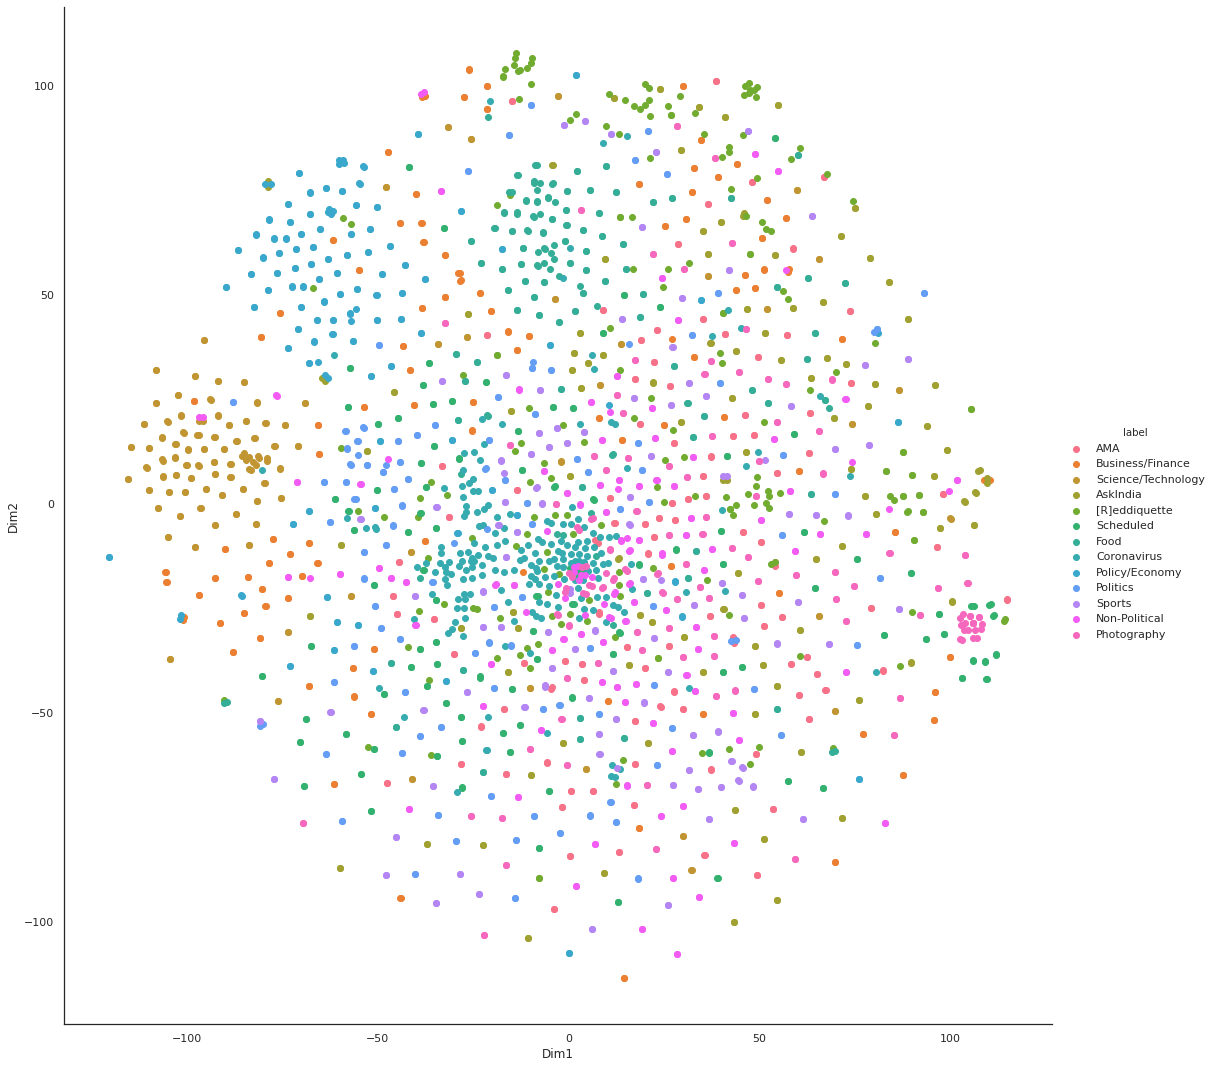

In [35]:
run_tsne(X_train_text_df,y_train,X_test_text_df,y_test, X_train_text_df.shape[1])

**Observation:** Some label clusters are disinctly separable and I conclude those classes to perform better at Classification (to the extent of false positives due to overfitting)

##### TF IDF Vectorizer

In [36]:
# Applying TFIDF
tfidf_comments = TfidfVectorizer(ngram_range=(1, 5), min_df=.1)

In [37]:
X_train_tfidf_comments = tfidf_comments.fit_transform(X_Train)
X_train_tfidf_text_df = pd.DataFrame(X_train_tfidf_comments.todense(), columns=[x+'_text' for x in tfidf_comments.get_feature_names()])
X_train_tfidf_text_df.shape

(1820, 206)

In [38]:
X_test_tfidf_comments = tfidf_comments.transform(X_Test)
X_test_tfidf_text_df = pd.DataFrame(X_test_tfidf_comments.todense(), columns=[x+'_text' for x in tfidf_comments.get_feature_names()])
X_test_tfidf_text_df.shape

(780, 206)

In [39]:
#saving bow model to a pickle file
filename = 'tfidf_vec.pkl'
joblib.dump(tfidf_comments, filename)

['tfidf_vec.pkl']

In [40]:
tfidf_comments.get_feature_names()

['able',
 'actually',
 'add',
 'almost',
 'already',
 'also',
 'always',
 'article',
 'ask',
 'back',
 'bad',
 'base',
 'be',
 'become',
 'believe',
 'better',
 'big',
 'bjp',
 'bot',
 'break',
 'bring',
 'business',
 'buy',
 'call',
 'can',
 'care',
 'case',
 'change',
 'check',
 'city',
 'come',
 'company',
 'could',
 'country',
 'day',
 'delete',
 'delhi',
 'different',
 'do',
 'economic',
 'economy',
 'else',
 'end',
 'enough',
 'even',
 'ever',
 'expect',
 'experience',
 'fact',
 'family',
 'far',
 'feel',
 'find',
 'first',
 'follow',
 'food',
 'free',
 'friend',
 'fuck',
 'get',
 'give',
 'go',
 'good',
 'government',
 'great',
 'guy',
 'hai',
 'happen',
 'hard',
 'have',
 'help',
 'high',
 'home',
 'hope',
 'html',
 'idea',
 'include',
 'indians',
 'instead',
 'issue',
 'job',
 'keep',
 'kind',
 'know',
 'last',
 'lead',
 'learn',
 'least',
 'leave',
 'less',
 'let',
 'level',
 'life',
 'link',
 'little',
 'live',
 'long',
 'look',
 'lose',
 'lot',
 'love',
 'low',
 'make',
 'm

t-SNE Completed. Total time it took: 30.968228101730347 seconds


/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


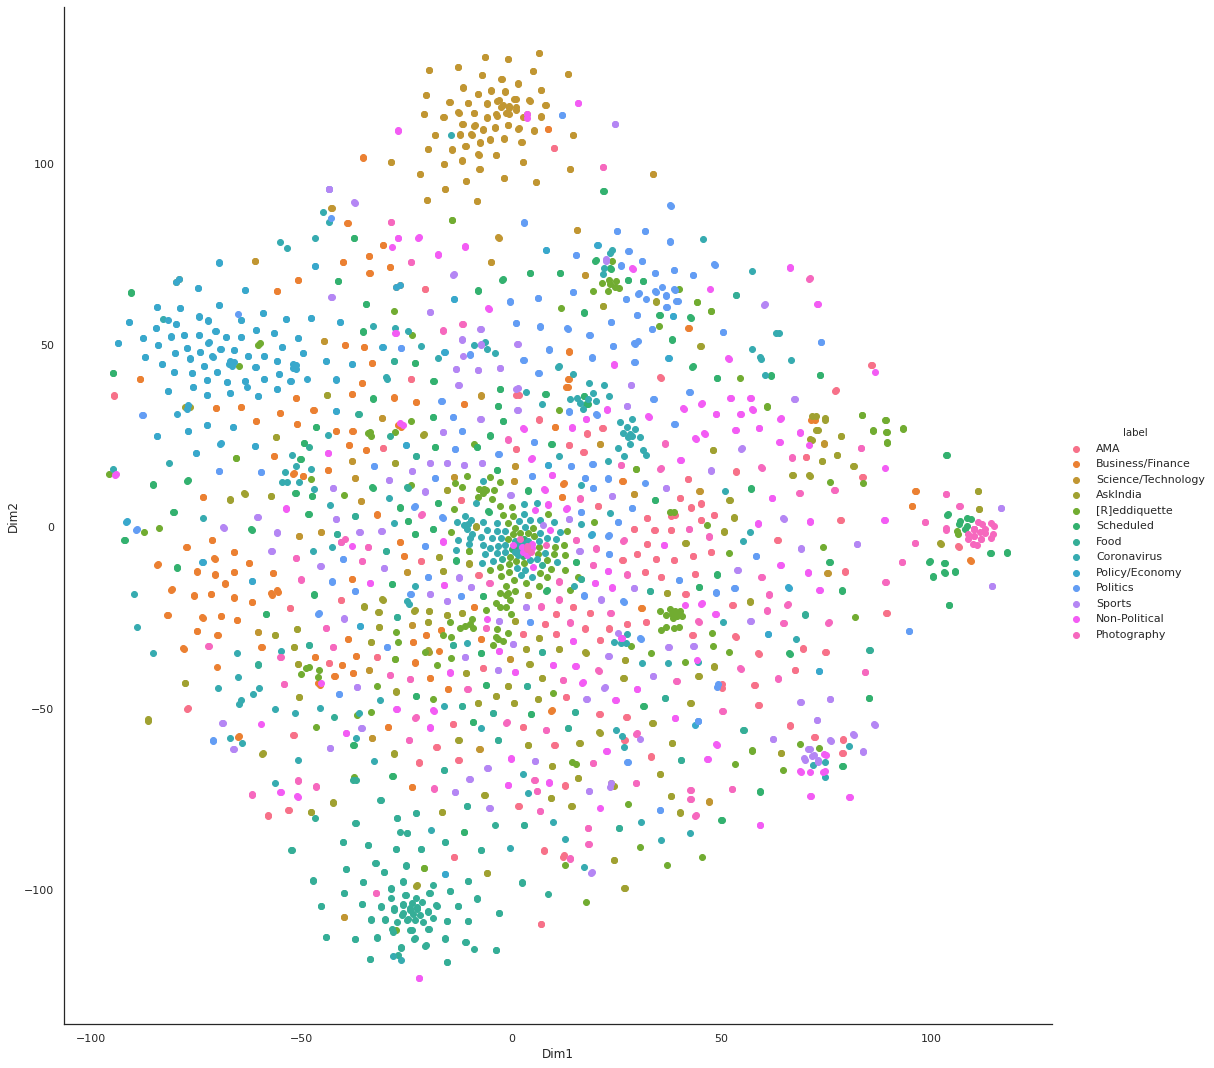

In [41]:
run_tsne(X_train_tfidf_text_df,y_train,X_test_tfidf_text_df,y_test, X_train_text_df.shape[1])

**Observation:** Label clusters are better separable and uniquely comprehendable, I suspect TF-IDF will perform better than BOW Vectorizer

##### Word2Vec Vectorizer

In [42]:
X_tr, X_cv, y_tr, y_cv = train_test_split(flair_data['combined_cleaned'], flair_data['label'], test_size=0.3)

In [43]:
list_of_sent=[]
for sent in X_tr.values:
    filtered_sentence=[]
    for w in sent.split():
        if(w.isalpha()):    
            filtered_sentence.append(w.lower())
        else:
            continue 
    list_of_sent.append(filtered_sentence)

In [44]:
# w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [45]:
# words = list(w2v_model.wv.vocab)
from itertools import islice
list(islice(wv.vocab, 13030, 13050))

['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

In [46]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [47]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
# train, test = train_test_split(df, test_size=0.3, random_state = 42)
train, test = train_test_split(flair_data[['combined_cleaned','label']], test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['combined_cleaned']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['combined_cleaned']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.8153846153846154
                    precision    recall  f1-score   support

          Politics       0.86      0.88      0.87        57
       Photography       0.53      0.74      0.62        47
    Policy/Economy       0.88      0.91      0.89        56
          AskIndia       0.88      0.81      0.84        57
            Sports       0.89      0.88      0.88        64
     Non-Political       0.73      0.78      0.76        60
         Scheduled       0.85      0.93      0.89        56
Science/Technology       0.86      0.88      0.87        57
              Food       0.79      0.84      0.81        67
  Business/Finance       0.97      0.84      0.90        75
       Coronavirus       1.00      0.81      0.90        70
               AMA       0.87      0.82      0.84        56
     [R]eddiquette       0.50      0.47      0.48        58

          accuracy                           0.82       780
         macro avg       0.82      0.81      0.81       780
      weig

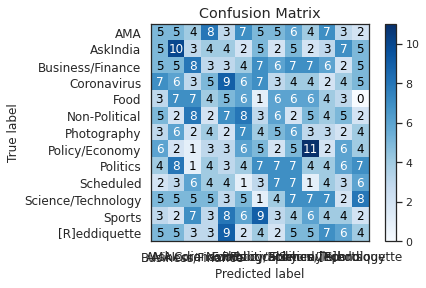

In [48]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['label'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.label))
print(classification_report(test['label'], y_pred,target_names=flairs))
print(skplt.plot_confusion_matrix(y_test, y_pred))

**Observation:** Average Word2Vec (with pre-loaded vectors) Vectorized data seems to perform worse, and possibly overfits by a large margin and hence I won't be using it. (similar models were run for prevous vectorizers and the seemingly performed better and hence were pickled)